# Requerimentos

In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geobr
import random
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def ConstructDfPivotLags(df_operacao):
    df_aux = ConstructDfPivot(df_operacao)
    for coluna in ['valor_principal_Port + Refin_M', 'valor_principal_Prod_M', 'valor_principal_Refin_M','valor_principal_Port + Refin_F', 'valor_principal_Prod_F', 'valor_principal_Refin_F']:
        df_aux[f'{coluna}_lag_1'] = df_aux[coluna].shift(1)  # Lag de 1 período
        df_aux[f'{coluna}_lag_2'] = df_aux[coluna].shift(2)  # Lag de 3 períodos
        df_aux[f'{coluna}_lag_3'] = df_aux[coluna].shift(3)  # Lag de 3 períodos
        df_aux[f'{coluna}_lag_4'] = df_aux[coluna].shift(4)  # Lag de 3 períodos
        df_aux[f'{coluna}_lag_5'] = df_aux[coluna].shift(5)  # Lag de 3 períodos
    return df_aux

def AutoCorrelation(df_operacao, genero):
    df_aux = ConstructDfPivot(df_operacao)
    fig, axs = plt.subplots(2, 3,figsize=(14, 7))
    plt.subplots_adjust(hspace=0.4)
    plt.subplots_adjust(wspace=0.7)
    colunas = [f'valor_principal_Port + Refin_{genero}', f'valor_principal_Prod_{genero}', f'valor_principal_Refin_{genero}']
    for j in range(3):
    # Assuming 'data' is the time series data
        coluna = colunas.pop()
        plot_acf(df_aux[coluna].values, lags=20, title=f'Autocorrelation: {coluna}', ax=axs[0][j])
        plot_pacf(df_aux[coluna].values, lags=20, title=f'Partial AutoCorrelation: {coluna}', ax=axs[1][j])
    plt.show()


def AdFuller(df_operacao):
    df_aux = ConstructDfPivot(df_operacao)
    # Assuming 'data' is the time series data
    result1 = adfuller(df_aux['valor_principal_Port + Refin_M'].values)
    result2 = adfuller(df_aux['valor_principal_Prod_M'].values)
    result3 = adfuller(df_aux['valor_principal_Refin_M'].values)
    result4 = adfuller(df_aux['valor_principal_Port + Refin_F'].values)
    result5 = adfuller(df_aux['valor_principal_Prod_F'].values)
    result6 = adfuller(df_aux['valor_principal_Refin_F'].values)

    return pd.DataFrame([(result1[0], result1[1]),(result2[0], result2[1]),(result3[0], result3[1]),(result4[0], result4[1]),(result5[0], result5[1]),(result6[0], result6[1])],
                        columns=['ADF Statistic', 'p-value'], index=['Port + Refin_M', 'Prod_M', 'Refin_M', 'Port + Refin_F', 'Prod_F', 'Refin_F' ])

def PlotEstado(df_operacao, state):

    df_aux = df_operacao.copy()
    df_aux['ano_mes'] = pd.to_datetime(pd.to_datetime(df_aux['data_operacao']).dt.strftime('%Y-%m') + '-01')
    df_aux = df_aux[df_aux['estado']!='Null'].groupby(['ano_mes','estado']).agg({'valor_principal': 'sum', 'contrato': 'count'}).reset_index().rename(columns={'contrato':'Quantidade de registros'})
    fig, axs = plt.subplots(2, 2,figsize=(14, 7))

    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator(1) ### where to put the label

    plt.subplots_adjust(hspace=0.4)
    plt.subplots_adjust(wspace=0.3)

    state.plot(
        column="valor_principal",
        cmap="GnBu",
        edgecolor="lightgray",
        legend=True,
        legend_kwds={
            "label": "valor_principal",
            "orientation": "horizontal",
            "shrink": 0.6,
        },
        ax=axs[0][0],
    )
    axs[0][0].set_title("Valor Carteira por estado brasileiro")
    axs[0][0].axis("off")

    axs[0][1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axs[0][1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis

    for coluna in df_aux['estado'].unique():
        axs[0][1].plot('ano_mes', 'valor_principal', random.choice(['cornflowerblue', 'lightsteelblue', 'royalblue', 'skyblue', 'teal']), data=df_aux[df_aux['estado'] == coluna])

    axs[0][1].set_title('Valor Carteira por estado')

    state.plot(
        column="Quantidade de registros",
        cmap="GnBu",
        edgecolor="lightgray",
        legend=True,
        legend_kwds={
            "label": "valor_principal",
            "orientation": "horizontal",
            "shrink": 0.6,
        },
        ax=axs[1][0],
    )
    axs[1][0].set_title("Valor Carteira por estado brasileiro")
    axs[1][0].axis("off")


    axs[1][1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axs[1][1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis

    for coluna in df_aux['estado'].unique():
        axs[1][1].plot('ano_mes', 'Quantidade de registros', random.choice(['cornflowerblue', 'lightsteelblue', 'royalblue', 'skyblue', 'teal']), data=df_aux[df_aux['estado'] == coluna])

    axs[1][1].set_title('Volume de Operações por estado')

    plt.show()


def states(df_operacao):
    state = geobr.read_state(year=2019)
    state.loc[state['name_state']=='Amazônas', 'name_state'] = 'Amazonas'
    state.loc[state['name_state']=='Rio Grande Do Norte', 'name_state'] = 'Rio Grande do Norte'
    state.loc[state['name_state']=='Rio De Janeiro', 'name_state'] = 'Rio de Janeiro'
    state.loc[state['name_state']=='Rio Grande Do Sul', 'name_state'] = 'Rio Grande do Sul'
    state.loc[state['name_state']=='Mato Grosso Do Sul', 'name_state'] = 'Mato Grosso do Sul'
    state = state.merge(df_operacao.groupby('estado').agg({'valor_principal': 'sum', 'data_operacao': 'count'}).reset_index().rename(columns={'data_operacao':'Quantidade de registros'}),
                         how="left", left_on="name_state", right_on="estado")
    return state

def PlotHistogramas(df_operacao):
    df_aux = df_operacao.copy()
    df_aux['ano_mes'] = pd.to_datetime(pd.to_datetime(df_aux['data_operacao']).dt.strftime('%Y-%m') + '-01')

    num_grap = len(df_operacao.select_dtypes([float, int]).columns[1:])

    fig, axs = plt.subplots(int(num_grap/3)+1, 3,figsize=(16, 10))
    plt.subplots_adjust(wspace=0.5)
    plt.subplots_adjust(hspace=0.5)

    colunas = list(df_aux.select_dtypes([float, int]).columns[1:])
    for i in range(int(num_grap/3)+1):
        for j in range(3):
            if not colunas:
                formatter = mdates.DateFormatter("%Y") ### formatter of the date
                locator = mdates.YearLocator(1) ### where to put the label

                axs[i][j].plot('ano_mes', 'Quantidade de registros', random.choice(['cornflowerblue']),
                                 data=df_aux.groupby('ano_mes').agg({'contrato':'count'}).rename(columns={'contrato': 'Quantidade de registros'}).reset_index())

                axs[i][j].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
                axs[i][j].xaxis.set_major_locator(locator) ## calling the locator for the x-axis

                axs[i][j].set_title(f'Volume de Operações')
                axs[i][j].set_xlabel('Data')
                axs[i][j].set_ylabel('Frequência')
                continue
            coluna = colunas.pop()
            sns.histplot(df_aux[coluna].values, bins=25, kde=True, color='lightsteelblue', edgecolor='cornflowerblue', ax = axs[i][j])
            axs[i][j].set_title(f'Histograma de {coluna}')
            axs[i][j].set_xlabel('Valores')
            axs[i][j].set_ylabel('Frequência')
    plt.show()

def PlotPyramid(df_operacao):
    df_aux = df_operacao.copy()
    df_aux['idade'] = df_aux['idade'].replace('Null', 0).astype(int).astype(str)
    df_aux = df_aux.groupby(['idade', 'genero']).agg({'valor_principal':'sum'}).unstack(1).reset_index()
    ages = sorted(list(df_aux['idade'].astype(int).astype(str).unique()), reverse=True)[:-2]
    df_aux[('valor_principal', 'M')] = -df_aux[('valor_principal', 'M')]

    fig, axs = plt.subplots(1, 2,figsize=(14, 7))

    sns.barplot(x=('valor_principal', 'M'), y='idade', data=df_aux, order=ages, color='darkblue', ax=axs[0])
    sns.barplot(x=('valor_principal', 'F'), y='idade', data=df_aux, order=ages, color = 'brown', ax=axs[0])
    axs[0].set_title("Valor Carteira por gênero e idade")
    axs[0].set_xlabel("Homem - Mulher")
    axs[0].set_xticks(ticks=[-5e6, -2.5e6, 0, 2.5e6, 5e6],
    labels=['5M', '2.5M','0', '2.5M','5M'])

    df_aux2 = df_operacao.copy()
    df_aux2['idade'] = df_aux2['idade'].replace('Null', 0).astype(int).astype(str)
    df_aux2 = df_aux2.groupby(['idade', 'genero']).agg({'contrato':'count'}).unstack(1).reset_index()
    ages = sorted(list(df_aux2['idade'].astype(int).astype(str).unique()), reverse=True)[:-2]
    df_aux2[('contrato', 'M')] = -df_aux2[('contrato', 'M')]

    sns.barplot(x=('contrato', 'M'), y='idade', data=df_aux2, order=ages, color='darkblue', ax=axs[1])
    sns.barplot(x=('contrato', 'F'), y='idade', data=df_aux2, order=ages, color = 'brown', ax=axs[1])

    axs[1].set_title("Volume de Operações por gênero e idade")
    axs[1].set_xlabel("Homem - Mulher")
    axs[1].set_xticks(ticks=[-150, -100, 0, 100, 150],
    labels=['150', '100','0', '100','150'])

    plt.show()

def PlotTimeSeries(df_operacao, genero):
    df_aux = ConstructDfPivot(df_operacao)

    df_aux_inicial = ConstructDfPivot(df_operacao)
    fig, axs = plt.subplots(2, 2,figsize=(14, 7))

    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator(1) ### where to put the label

    plt.subplots_adjust(hspace=0.4)
    plt.subplots_adjust(wspace=0.3)

    axs[0][0].stackplot(df_aux['ano_mes'].values,
                        df_aux[f'valor_principal_Refin_{genero}'].values,
                    df_aux[f'valor_principal_Port + Refin_{genero}'].values,
                        df_aux[f'valor_principal_Prod_{genero}'].values,
                        labels=['Refin','Port + Refin','Prod'], colors=['lightblue','lightgray','steelblue'])

    axs[0][0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axs[0][0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axs[0][0].set_title(f'Valor Carteira consolidado por operacao')
    axs[0][0].legend(loc='upper left')

    axs[0][1].stackplot(df_aux['ano_mes'].values,
                    df_aux[f'contrato_Refin_{genero}'].values,
                    df_aux[f'contrato_Port + Refin_{genero}'].values,
                        df_aux[f'contrato_Prod_{genero}'].values,
                        labels=['Refin','Port + Refin','Prod'], colors=['darkkhaki','navajowhite','goldenrod'])

    axs[0][1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axs[0][1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axs[0][1].set_title(f'Volume de Operações consolidado por operacao')
    axs[0][1].legend(loc='upper left')

    axs[1][0].plot(df_aux['ano_mes'].values,
                    df_aux[f'valor_principal_Port + Refin_{genero}'].values,label='Port + Refin', color='lightgray')
    axs[1][0].plot(df_aux['ano_mes'].values,
                    df_aux[f'valor_principal_Refin_{genero}'].values,label='Refin', color='lightblue')
    axs[1][0].plot(df_aux['ano_mes'].values,
                    df_aux[f'valor_principal_Prod_{genero}'].values, label='Prod', color='steelblue')

    axs[1][0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axs[1][0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axs[1][0].set_title(f'Valor Carteira por operacao')
    axs[1][0].legend(loc='upper left')

    axs[1][1].plot(df_aux['ano_mes'].values,
                    df_aux[f'contrato_Port + Refin_{genero}'].values,label='Port + Refin', color='darkkhaki')
    axs[1][1].plot(df_aux['ano_mes'].values,
                    df_aux[f'contrato_Refin_{genero}'].values,label='Refin', color='navajowhite')
    axs[1][1].plot(df_aux['ano_mes'].values,
                    df_aux[f'contrato_Prod_{genero}'].values, label='Prod', color='goldenrod')

    axs[1][1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axs[1][1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axs[1][1].set_title(f'Volume de Operações Carteira por operacao')
    axs[1][1].legend(loc='upper left')

    plt.show()

def ConstructDfPivot(df_operacao):
    
  df_aux_inicial = df_operacao.copy()
  df_auxm = df_aux_inicial[df_aux_inicial['genero']=='M'].groupby(['ano_mes', 'operacao','genero']).agg({'valor_principal':'sum', 'contrato':'count'}).unstack(1).reset_index()
  df_auxm.columns = [i+'_'+j+'_M' for i,j in df_auxm.columns]
  df_auxm['valor_principal_m'] = df_auxm['valor_principal_Port + Refin_M'] + df_auxm['valor_principal_Prod_M'] + df_auxm['valor_principal_Refin_M']
  df_auxm['quantidade_m'] = df_auxm['contrato_Port + Refin_M'] + df_auxm['valor_principal_Prod_M'] + df_auxm['contrato_Refin_M']

  df_auxh = df_aux_inicial[df_aux_inicial['genero']=='F'].groupby(['ano_mes', 'operacao', 'genero']).agg({'valor_principal':'sum', 'contrato':'count'}).unstack(1).reset_index()
  df_auxh.columns = [i+'_'+j+'_F' for i,j in df_auxh.columns]
  df_auxh['valor_principal_F'] = df_auxh['valor_principal_Port + Refin_F'] + df_auxh['valor_principal_Prod_F'] + df_auxh['valor_principal_Refin_F']
  df_auxh['quantidade_f'] = df_auxh['contrato_Port + Refin_F'] + df_auxh['valor_principal_Prod_F'] + df_auxh['contrato_Refin_F']

  df_aux = df_auxh.merge(df_auxm, how='left', left_on=['ano_mes__F'], right_on=['ano_mes__M']).rename(columns={'ano_mes__F': 'ano_mes'}).drop(columns=['ano_mes__M'])
  return df_aux


In [2]:
df_operacao = pd.read_csv('dados/dados_operacoes.csv')
df_operacao['ano_mes'] = pd.to_datetime(pd.to_datetime(df_operacao['data_operacao']).dt.strftime('%Y-%m') + '-01')

# Análise exploratória

##### Resumo

Neste notebook será feita análise exploratória de dados. Objetivo final é encontrar variáveis que se relacionem de maneira positiva com a variável "valor_principal" e com o "Volume de operações por mês", que será computada como a quantidade de contratos por ano mês, para que seja possível prever o valor da carteira e o volume de operações para o período dos próximos dois anos. É assumido por hipótese que o valor da carteira em um ano mês é dado pela soma da variável "valor_principal" para todos os registros do ano mês correspondente.

##### Estrutura arquivo

A estrutura do arquivo básico, com nome, descrição e tipo de dados das colunas segue abaixo:

| Coluna | Descrição  | Tipo |
|-----|---| ---|
| id | Coluna que identifica o cliente | chavemd5 |
| contrato  | Contrato referente a produto ativo do cliente | String |
|data_operacao| Data que o contrato foi feito| Datetime |
|nascimento| Data de nascimento do cliente| Datetime |
|idade| Idade cliente| Inteiro |
|genero| Gênero cliente | String |
|bairro| Bairro cliente | String |
|cidade| Cidade cliente | String |
|estado| Estado cliente | String |
|cep| CEP cliente | String |
|telefone| Telefone cliente | String |
|cartao| Código do Cartao cliente | String |
|email| Email do cliente | String |
|ocupacao| Profissão do cliente | String |
|empregador| Empregador do cliente | String |
|operacao| Tipo de produto contrato | String |
|quantidade_parcelas| Quantidade de parcelas do contrato | Inteiro |
|parcelas_pagas| parcelas pagas | Inteiro |
|quantidade_parcelas_pagas| quantidade_parcelas_pagas | Inteiro |
|taxa_contrato|taxa_contrato| Float |
|valor_parcela| valor_parcela | Float |
|valor_bruto| valor_bruto | Float |



#### Análises com variáveis categóricas

##### Gráficos regionais

Nos gráficos abaixo são construídos gráficos regionais e das séries temporais, para variáveis de valor_principal e volume de operação. Para o gráfico de série temporal, cada linha representa um estado diferente no decorrer do tempo.

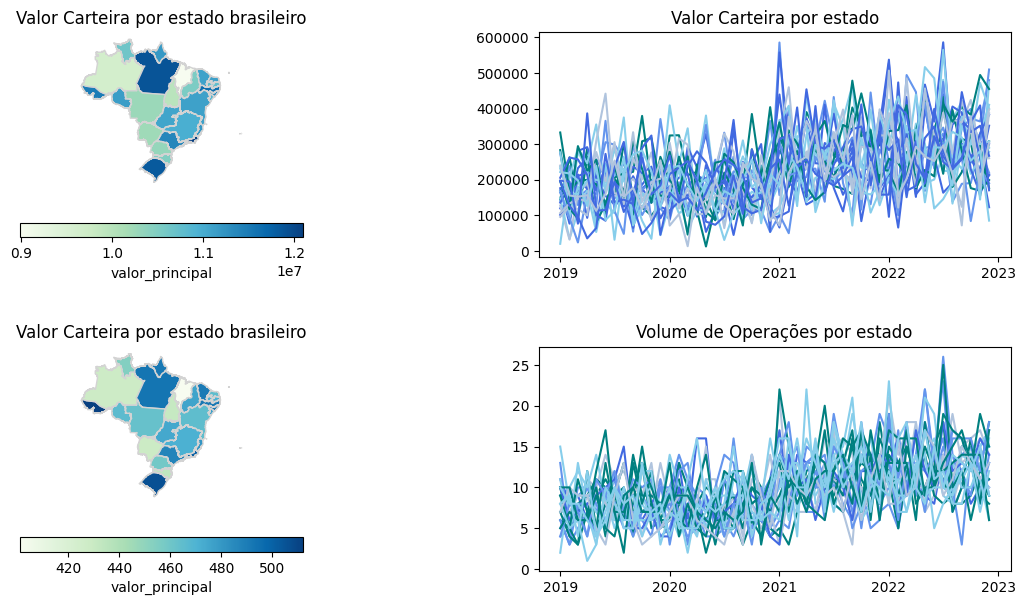

In [3]:
PlotEstado(df_operacao, states(df_operacao));

Tanto a variável valor_principal quanto a quantidade de registros estão com tendência de aumento com o passar do tempo.

##### Distribuição de valor_principal e volume de operações por gênero e idade

Abaixo é feita gráfico para verificar como estão distribuídas as variáveis valor_principal e quantidade de registros, agrupadas por gênero e idade.

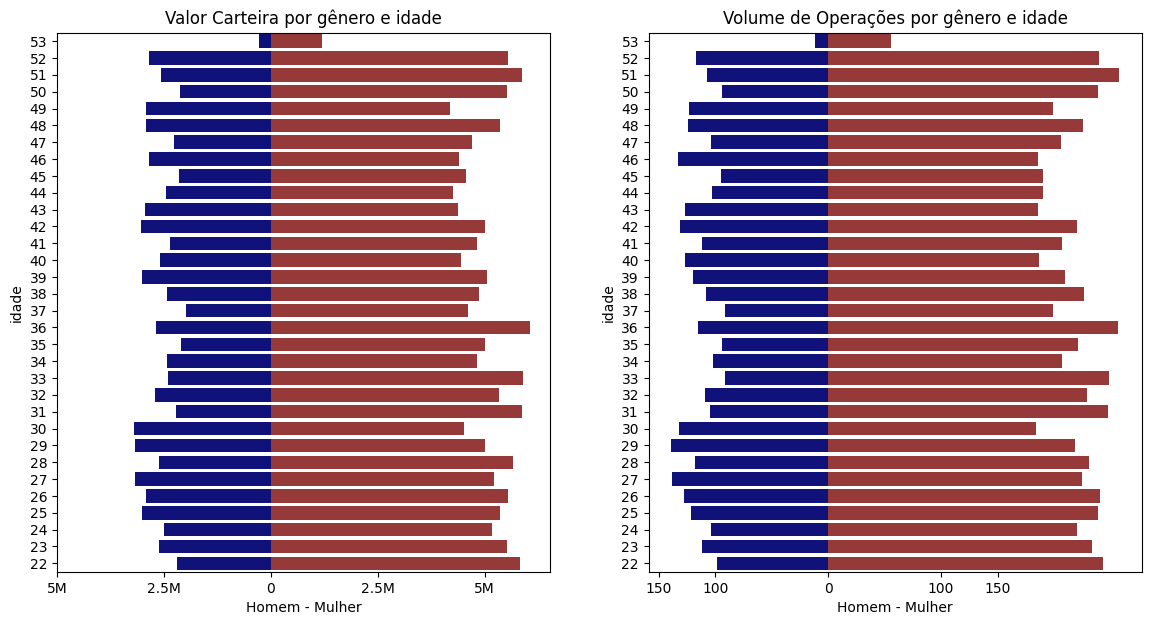

In [4]:
PlotPyramid(df_operacao)

É nítido que em geral existem mais contratos e os valores são maiores para o gênero feminino, do que para o o masculino, para todas as idades. A idade por sua vez parece não ter tanta influência sobre as variáveis valor_principal e quantidade de registros, pois os valores estão sempre bem próximos em toda a base.

##### Variação mensal por tipo de operacao

* Feminino

A variável operacao tem 3 dimensões. Aqui, iremos investigar como está o gráfico de data por tipo de operação. Abaixo temos gráficos de valor_principal e volume da operação agrupados por tipo de verba para dar uma visão tanto consolidada quanto uma visão isolada.

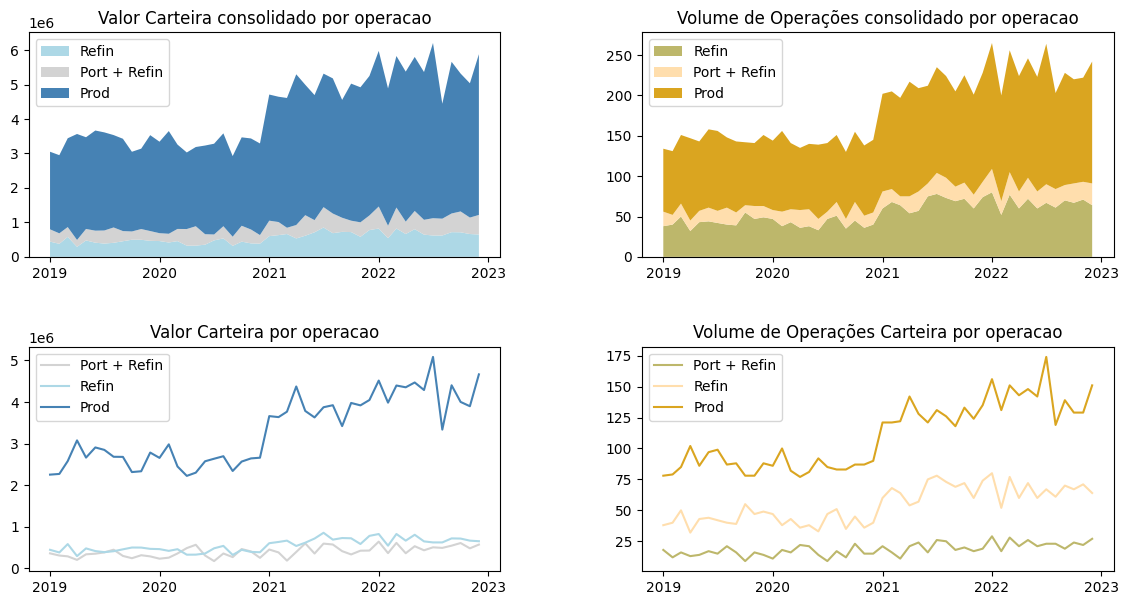

In [5]:
PlotTimeSeries(df_operacao, 'F')

Dos gráficos acima, é possível observar que as duas séries são bem correlacionadas. É possível também ver a tendência geral dos contratos por tipo de operação para o genêro feminino. Os graficos enfatizam crescimento da operação "Prod", enquanto "Refin" e "Port + Refin" tem leve aumento no volume da operação, que não se refletem tanto na variação valor_principal. 
Para o valor_principal é possível ver que a carteira em geral dobrou de tamanho após o final de 2021, aumento motivado principalmente pela alta de operações "Prod".

* Masculino

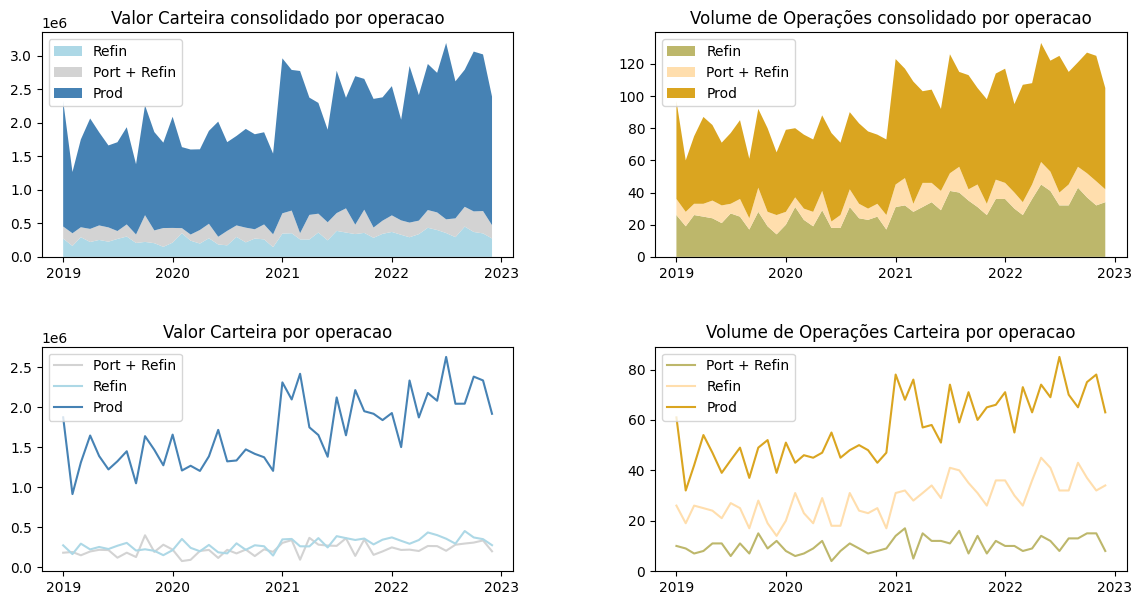

In [6]:
PlotTimeSeries(df_operacao, 'M')

Nas séries masculinas de valor e volume de operações, é possível verificar que a série de "Prod" apresenta certa linearidade e tendência de crescimento, que dita o ritmo da carteira tanto em volume de operação quanto em valor. Refin e Port + Refin apresentam ligeira tendência de crescimento.

Com os gráficos acima é possível verificar a importância que a variável operacao tem na carteira, e é verificado que existe uma tendência linear positiva na serie temporal de Prod.

#### Testes Estátisticos

##### Histogramas variáveis numéricas

Abaixo foram construídos histogramas para as variáveis númericas: 

* valor_bruto
* valor_parcela
* taxa_contrato
* quantidade_parcelas_pagas
* parcelas_pagas
* quantidade_parcelas
* parcelas
* valor_principal

Atenção especial para o histograma da variável "valor_principal" e o último gráfico que é uma série temporal com a quantidade de registros por ano mês.

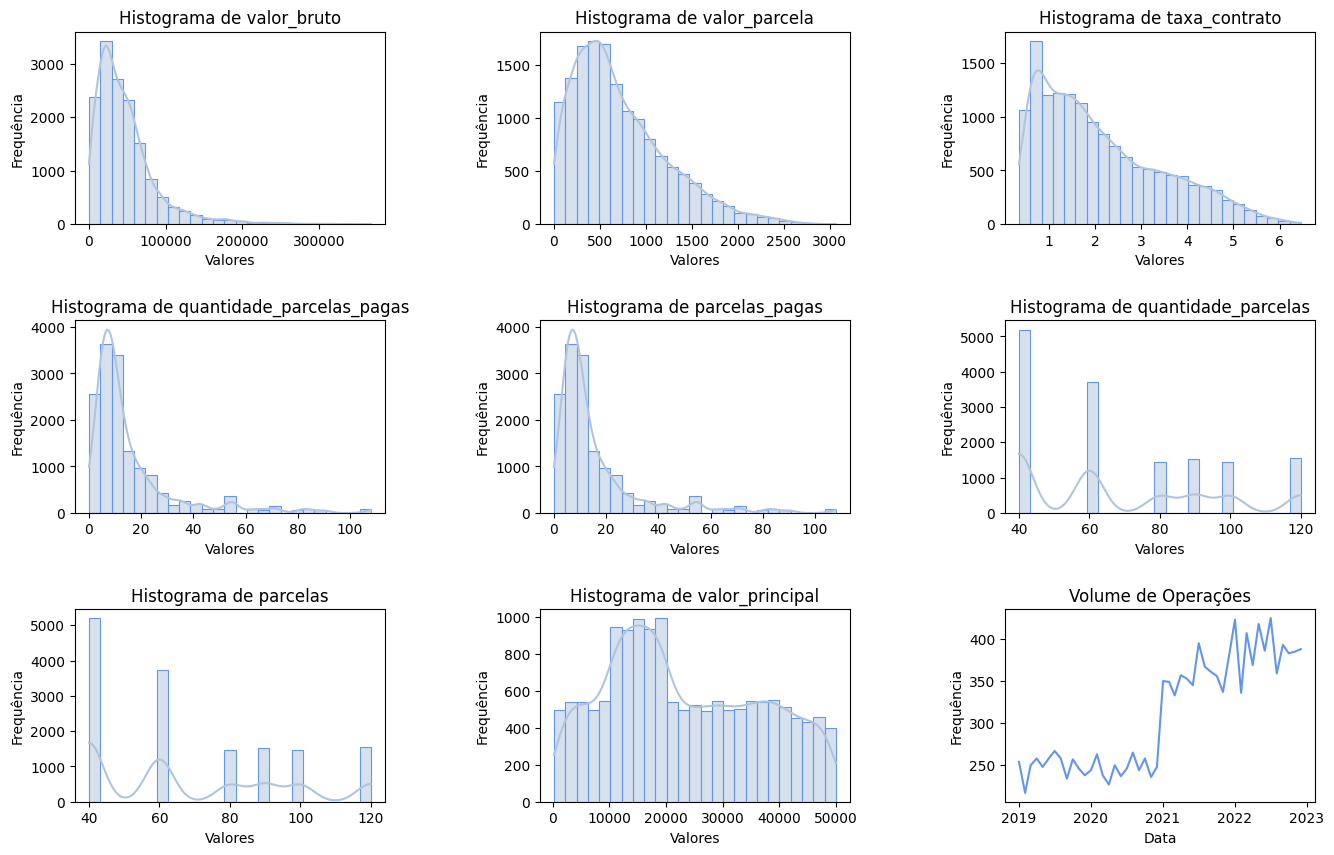

In [7]:
PlotHistogramas(df_operacao)

Acima, é possível ver com enfase especial que a variável valor_principal está igualmente distribuída em toda a base, com exceção do intervalo entre 10 e 20 mil, que possui aproximadamente o dobro de registros que a média. 
Já para a variável Quantidade de registros, é possível observar que existe uma grande alta do volume de operações com o passar do tempo, mas apesar de ter existido um salto em 2021, os valores não continuaram crescendo tão rapidamente.

##### Matriz correlação Variáveis primárias

Abaixo temos gráfico com coeficiente de correlação para as variáveis primárias da tabela. 

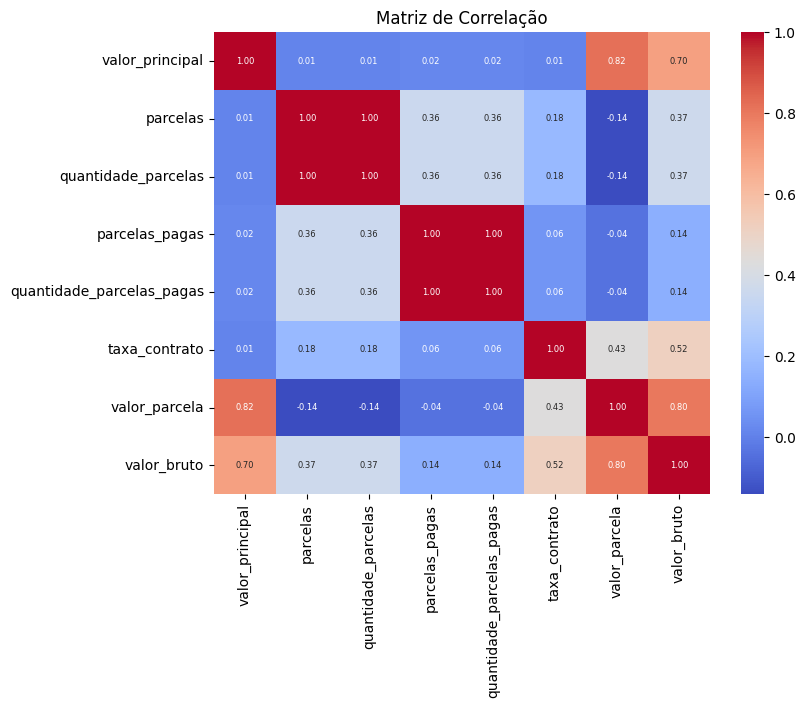

In [8]:
matriz_correlacao = df_operacao[df_operacao.select_dtypes([float, int]).columns[1:]].corr()
plt.figure(figsize=(8, 6))
mapa_calor = sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"fontsize":6})

# Exibindo o gráfico
plt.title('Matriz de Correlação')
plt.show()

É possível notar que o valor_principal está com correlação média-alta com as variáveis valor_parcela e valor_bruto.

##### Addfuller

Abaixo, o teste addfuller indica que as series de Port + Refin de valor_principal são estacionárias tanto para o gênero masculino quanto para o feminino.

In [9]:
AdFuller(df_operacao)

,ADF Statistic,p-value
Port + Refin_M,-3.601271,0.005737
Prod_M,-2.124452,0.234797
Refin_M,-1.712072,0.424904
Port + Refin_F,-4.577066,0.000142
Prod_F,-0.460132,0.899564
Refin_F,-1.736381,0.412472


##### Autocorrelação

* Autocorrelação gênero Feminino valor_principal

Abaixo tem-se os gráficos que servem para investigar se as series temporais de valor_principal para o gênero feminino, segregadas por operação possuem autocorrelação.

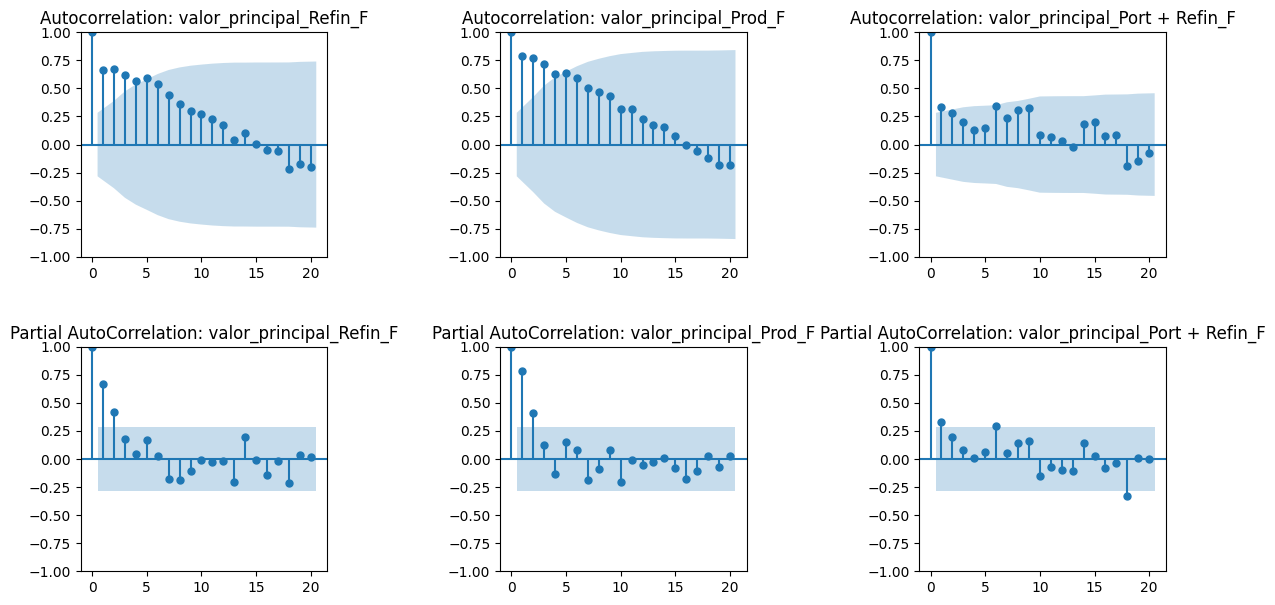

In [10]:
AutoCorrelation(df_operacao, 'F')

Acima, é possível ver que as series do gênero feminino Refin e Prod apresentam alta correlação principalmente para lags menores ou iguais a 5. 

* Autocorrelação Séries gênero masculino valor_principal

Abaixo é visto os gráficos que servem para investigar se as series temporais para o gênero masculino, segregadas por operação possuem autocorrelação.

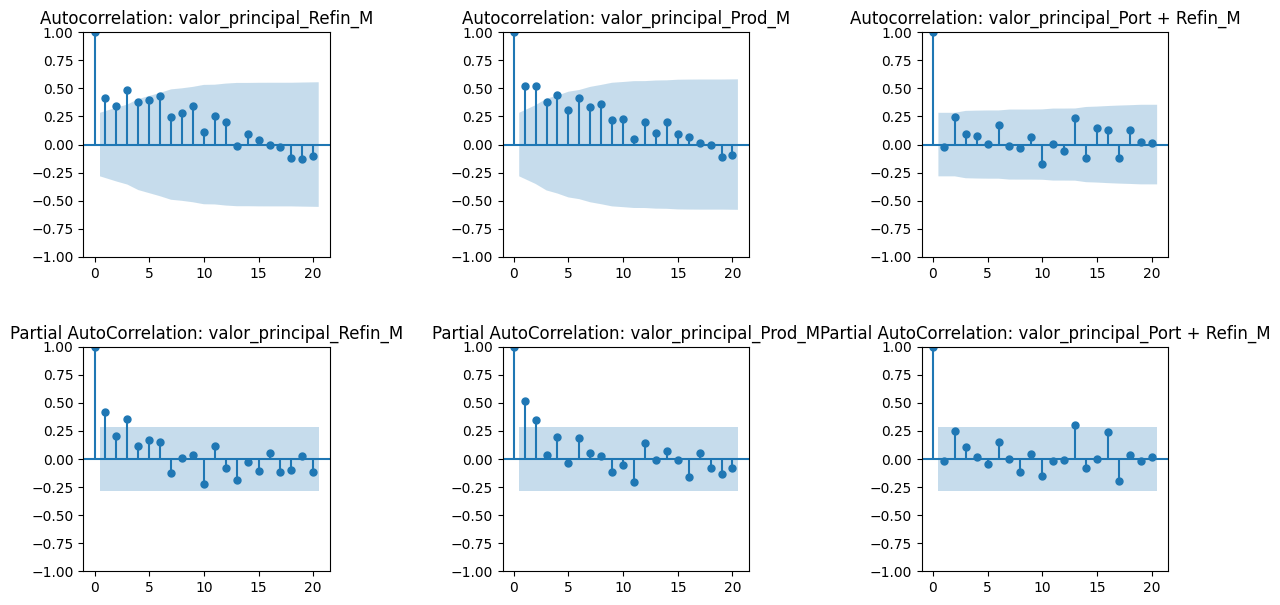

In [11]:
AutoCorrelation(df_operacao, 'M')

Para as séries do gênero masculina, é possível observar que as operações Refin e Prod, possuem forte autocorrelação com lags 1,2,3. Enquanto que o produto Port + Refin aparenta não ter autocorrelação.

##### Correlação com lags

Abaixo, serão exibidos as matrizes de correlação para a serie temporal de operacao Prod e Refin para o valor_principal, genêros masculinos e femininos. Como mais uma evidência da autocorrelação, agora caracterizada como linear entre lags e o valor da variável valor_principal.

* Correlação lags feminino Prod

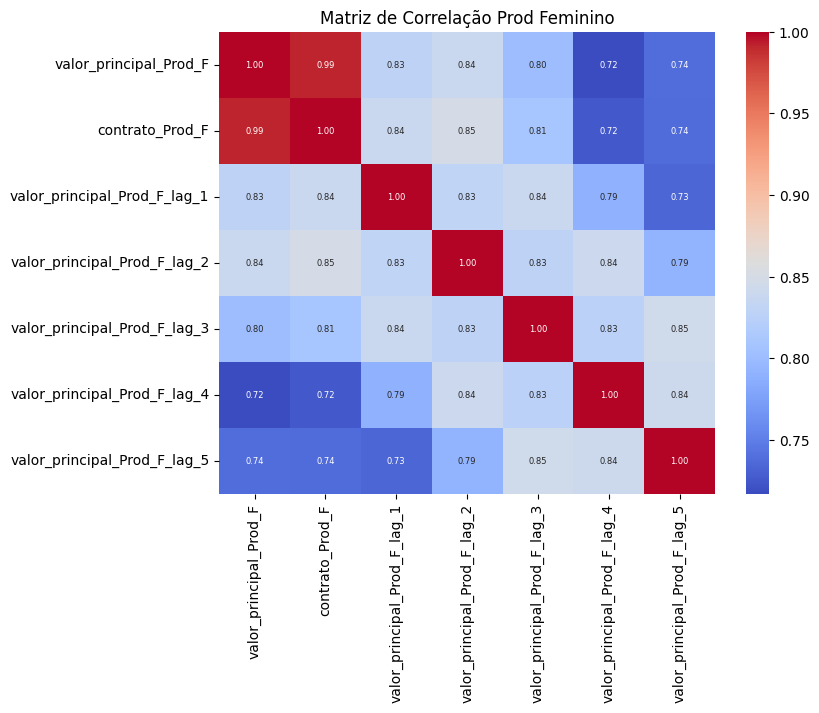

In [12]:
df_aux = ConstructDfPivotLags(df_operacao)
matriz_correlacao = df_aux[[i for i in df_aux.columns if 'Prod_F' in i]].corr()

plt.figure(figsize=(8, 6))
mapa_calor = sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"fontsize":6})

# Exibindo o gráfico
plt.title('Matriz de Correlação Prod Feminino')
plt.show()

* Correlação lags feminino Refin

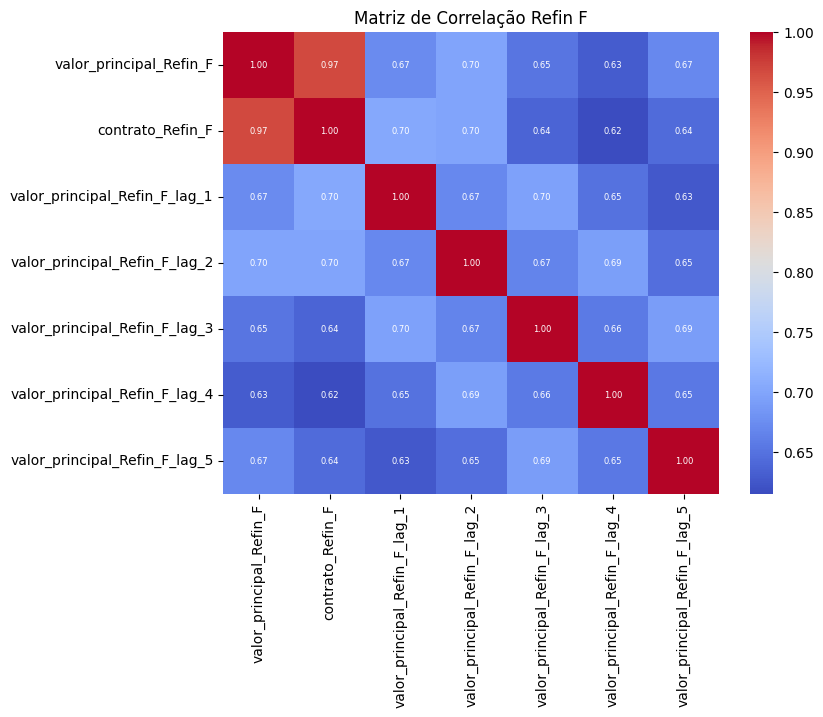

In [13]:
matriz_correlacao = df_aux[[i for i in df_aux.columns if 'Refin_F' in i and 'Port + Refin_F'not in i]].corr()

plt.figure(figsize=(8, 6))
mapa_calor = sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"fontsize":6})

# Exibindo o gráfico
plt.title('Matriz de Correlação Refin F')
plt.show()

* Correlação lags masculina Prod

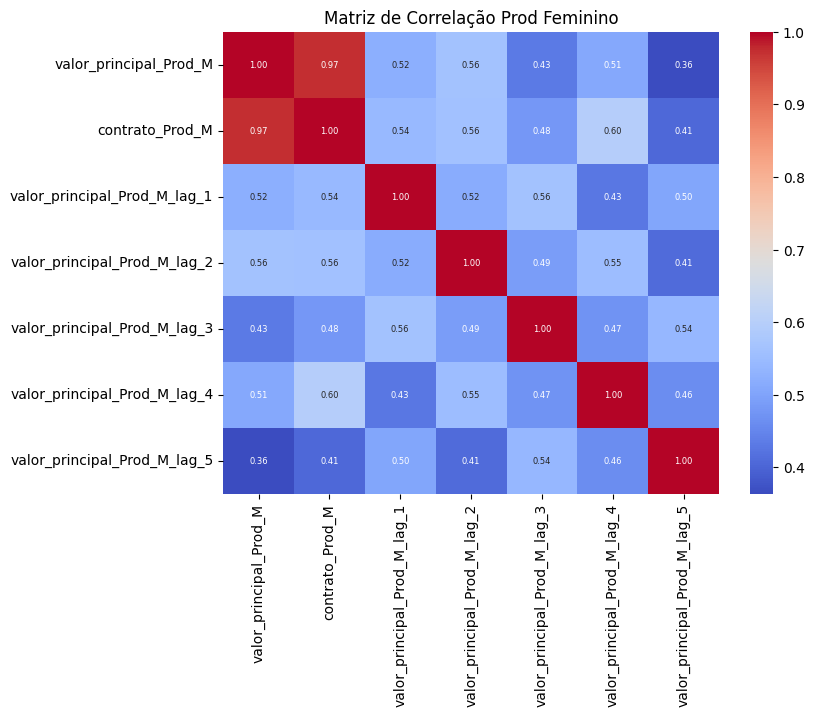

In [14]:
df_aux = ConstructDfPivotLags(df_operacao)
matriz_correlacao = df_aux[[i for i in df_aux.columns if 'Prod_M' in i]].corr()

plt.figure(figsize=(8, 6))
mapa_calor = sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"fontsize":6})

# Exibindo o gráfico
plt.title('Matriz de Correlação Prod Feminino')
plt.show()

* Correlação lags masculina Refin

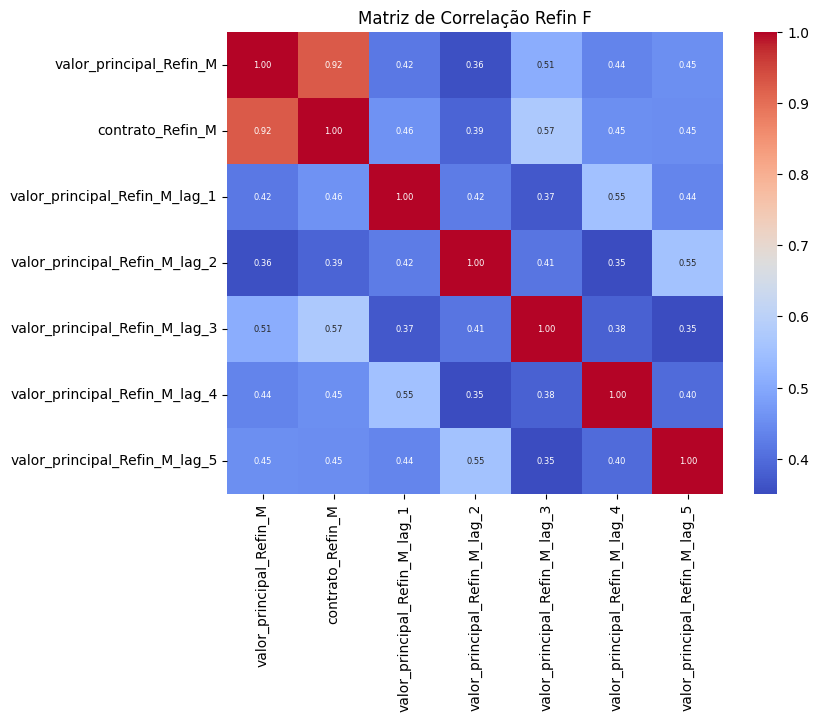

In [15]:
matriz_correlacao = df_aux[[i for i in df_aux.columns if 'Refin_M' in i and 'Port + Refin_M'not in i]].corr()

plt.figure(figsize=(8, 6))
mapa_calor = sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"fontsize":6})

# Exibindo o gráfico
plt.title('Matriz de Correlação Refin F')
plt.show()

# Insights

Principais insights são acerca dos fatos :
* Idade e estado tem distribuição muito parecida para todos os valores.
* Gênero tem distribuições diferentes, e as mulheres são a maioria em valor da carteira e em volume de operações.
* As séries de Valor da carteira e do Volume de operações são altamente correlacionada. 
* As séries de Valor da carteira possuí autocorrelação forte com lags quando agrupadas por operação Prod e Refin.
* As series de Valor da carteira possuem alta correlação linear quando agrupadas por operação Prod e Refin.
* A seríe de Valor da carteira Port + Refin é estacionária e não possui autocorrelação.